In [2]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
# Globals
NUM_CHANNELS = 3
RESOLUTION_LIST = [336] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
AUGMENTATION = 'occlusion_all'
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-base-PrPo_Im-w-336-px-h-336-px/model'

In [4]:
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, train=True, rectangular = False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, train=False, rectangular = False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [5]:
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")

training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[336]["PrPo_Im"])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[336]["PrPo_Im"])

In [6]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

Obtaining the class activation maps (CAM) and gradients from the three visualization techniques.

In [7]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    # class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(test_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in test_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = np.squeeze(test_images[cam_img])
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print(gradcam_image.shape)
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [7]:
grad_cam([18])

Observed image class:  Improbable
Loss output:  tf.Tensor([[ 17.229473 -29.56441 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=17.229473>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([1.000000e+00, 4.760738e-21], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


(array([[0.25008786, 0.27416226, 0.29823667, ..., 0.21085753, 0.1867415 ,
         0.16262542],
        [0.27536932, 0.30115667, 0.326944  , ..., 0.23423386, 0.20839901,
         0.18256415],
        [0.30065084, 0.3281511 , 0.35565135, ..., 0.25761017, 0.23005654,
         0.20250289],
        ...,
        [0.10619897, 0.12015285, 0.13410673, ..., 0.04167603, 0.03034781,
         0.0190196 ],
        [0.09156085, 0.10462315, 0.11768546, ..., 0.03052519, 0.02001749,
         0.0095098 ],
        [0.07692273, 0.08909344, 0.10126417, ..., 0.01937436, 0.00968718,
         0.        ]], dtype=float32),
 array([[[0.78039216, 0.84705882, 0.96470588],
         [0.78431373, 0.85098039, 0.96862745],
         [0.78039216, 0.84313725, 0.97254902],
         ...,
         [0.74509804, 0.80784314, 0.9372549 ],
         [0.74117647, 0.81176471, 0.93333333],
         [0.7372549 , 0.81176471, 0.92941176]],
 
        [[0.78039216, 0.83921569, 0.96078431],
         [0.78431373, 0.84313725, 0.96470588],
 

In [8]:
def guided_backprop(index, activation_layer):
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
#     print(validation_images[index].shape)
    backprop_image = test_images[index].reshape(1, 336, 336, 3)
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads

In [9]:
guided_backprop(18, 'conv2d_4')

<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[ 7.5213552e-01,  7.2539848e-01,  1.2425714e+00],
        [-1.0034578e+00,  4.2889314e+00,  1.0977767e+01],
        [ 3.4741018e+00,  3.1867981e+00,  6.7941656e+00],
        ...,
        [ 2.0154688e+00,  4.5900559e+00,  1.6542274e+01],
        [ 2.1988926e+00,  2.3814771e+00,  6.4868574e+00],
        [ 3.3754838e-01,  1.0818094e+00,  6.6764240e+00]],

       [[-2.6682353e-01,  2.4937000e+00,  4.7324228e+00],
        [-2.6122155e+00,  7.0398798e+00,  2.3174992e+01],
        [-6.5614760e-01,  1.0590410e+01,  2.2963642e+01],
        ...,
        [ 3.5275388e+00,  2.7135494e+01,  3.3233196e+01],
        [ 7.2006696e-01,  8.3009109e+00,  1.4665148e+01],
        [-6.4138901e-01,  1.0267845e+01,  1.2534206e+01]],

       [[ 2.5935826e+00,  1.9823022e+00,  3.2425065e+00],
        [-5.7823896e-02,  1.0300669e+01,  2.6306295e+01],
        [ 8.9408426e+00,  9.6924572e+00,  1.7739494e+01],
        ...,
        [ 1.5564010e+01,  1.8855

In [10]:
def guided_gradcam(index, activation_layer='conv2d_4'): #normalize=False
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    gbp  = guided_backprop([index], activation_layer)
    gcam = grad_cam([index])[0]
#     if normalize:
#         gbp = deprocess_image(np.array(np.squeeze(gbp)))
#     else:
#         gbp = np.squeeze(gbp)
    
    ggcam = gbp * gcam[..., np.newaxis]
#     print(gcam[..., np.newaxis])
    print('Shape of GGCAM: ', ggcam.shape)
    return ggcam

In [11]:
guided_gradcam(18, 'conv2d_4')

Observed image class:  Improbable
Loss output:  tf.Tensor([[ 17.229473 -29.56441 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=17.229473>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([1.000000e+00, 4.760738e-21], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)


<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[ 1.8809997e-01,  1.8141335e-01,  3.1075200e-01],
        [-2.7511024e-01,  1.1758631e+00,  3.0096893e+00],
        [ 1.0361046e+00,  9.5042002e-01,  2.0262692e+00],
        ...,
        [ 4.2497677e-01,  9.6784782e-01,  3.4880631e+00],
        [ 4.1062450e-01,  4.4472063e-01,  1.2113655e+00],
        [ 5.4893944e-02,  1.7592971e-01,  1.0857562e+00]],

       [[-7.3475011e-02,  6.8668848e-01,  1.3031640e+00],
        [-7.8668612e-01,  2.1201067e+00,  6.9793034e+00],
        [-2.1452351e-01,  3.4624710e+00,  7.5078249e+00],
        ...,
        [ 8.2626903e-01,  6.3560514e+00,  7.7843399e+00],
        [ 1.5006125e-01,  1.7299017e+00,  3.0562024e+00],
        [-1.1709464e-01,  1.8745404e+00,  2.2882967e+00]],

       [[ 7.7976280e-01,  5.9598082e-01,  9.7486228e-01],
        [-1.8974975e-02,  3.3801758e+00,  8.6324396e+00],
        [ 3.1798227e+00,  3.4471354e+00,  6.3090749e+00],
        ...,
        [ 4.0094471e+00,  4.8574

Visually rendering the outputs of the three functions and the original image from the validation set.

In [12]:
def renderOriginal(index, save=False, grid=False, c_map='gist_gray'):
    '''Plot the original image found in the validation set.'''
    originals_dir = '../../figures/plottingOriginals/'
    print('Observation: ',class_labels[np.argmax(training_labels[index])])
    if grid==False:
        standardizePlot(index, originals_dir, 'Original Image (validation) in '+ c_map)
        plt.imshow(np.squeeze(training_images[index]), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(training_images[index]), cmap=c_map)
    if save:
        plt.savefig(originals_dir+'original-'+str(index)+'-'+c_map+'.jpg')
    return training_images[index]

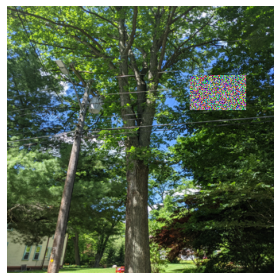

In [13]:
# for i in range(20,30, 3):
plt.axis('off')
plt.tight_layout()
plt.imshow(np.squeeze(training_images[319]), cmap='gist_gray')

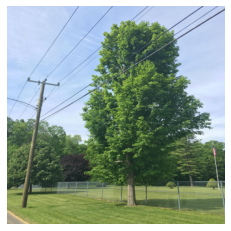

In [14]:
plt.axis('off')
plt.imshow(np.squeeze(test_images[18]), cmap='gist_gray')

In [8]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/'
    gcam = grad_cam([index])
    # class_labels = getClassLabels("PrPo_Im")
    
    if grid==False:
        plt.figure(figsize=(5, 5))
        # plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        plt.title('Observed class: '+class_labels[np.argmax(test_labels[index])], y=-0.08)
        plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    # print(gradcam_dir+"gradcam-"+str(index)[1:-1])
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"gradcam-"+str(index)+".png")
    return (heatmap)

In [9]:
def analyzePredictions(labels):
    """Returns the indices of the test images for both correct and incorrect predictions. 
    The total number for each class should equal the corresponding value in the confusion matrix.
    Currently only scenario PrPo_Im is supported."""
    im = labels[0]
    prPo = labels[1]
    predictions = {im+'_correct': [],
                   im+'_incorrect': [],
                   prPo+'_correct':[],
                   prPo+'_incorrect':[]}
    for i in range(len(test_labels)):
        observed = class_labels[np.argmax(test_labels[i])]
        predicted = str(grad_cam([i])[3])[2:-2]
        if observed == im:
            if predicted == observed:
                predictions[im+'_correct'].append(i)
            else:
                predictions[im+'_incorrect'].append(i)
        else:
            if predicted == observed:
                predictions[prPo+'_correct'].append(i)
            else:
                predictions[prPo+'_incorrect'].append(i)
    return predictions

In [10]:
predictions = analyzePredictions(class_labels)

Observed image class:  Improbable
Loss output:  tf.Tensor([[11.326737 18.184822]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=11.326737>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([0.00104982, 0.9989496 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[3.4638565 5.8679   ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.4638565>]
Probability of prediction:  ['0.92']
Predicted class:  ['Probable/Possible']
[array([0.08286487, 0.91713494], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[49.96393  -6.162091]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=49.96393>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([1.000000e+00, 4.214828e-25], dtype=float32)]
(336, 336, 3)
Shape of h

In [14]:
# class_labels[0] -> improbable; class_labels[1] -> probable/possible
print("Total number of test images:", len(test_images),'\n')
print("Indices of correct", class_labels[1], "predictions:", predictions[class_labels[1]+'_correct'], 'Total:', len(predictions[class_labels[1]+'_correct']), '\n')
print("Indices of correct", class_labels[0], "predictions:", predictions[class_labels[0]+'_correct'], 'Total:', len(predictions[class_labels[0]+'_correct']),'\n')
print("Indices of incorrect", class_labels[1], "predictions:", predictions[class_labels[1]+'_incorrect'], 'Total:', len(predictions[class_labels[1]+'_incorrect']),'\n')
print("Indices of incorrect", class_labels[0], "predictions:", predictions[class_labels[0]+'_incorrect'], 'Total:', len(predictions[class_labels[0]+'_incorrect']),)

Total number of test images: 350 

Indices of correct Probable/Possible predictions: [212, 213, 215, 216, 217, 218, 220, 224, 225, 226, 227, 229, 236, 238, 240, 242, 243, 244, 248, 249, 250, 251, 252, 257, 258, 259, 260, 261, 262, 264, 267, 268, 269, 270, 272, 275, 279, 280, 282, 283, 285, 287, 288, 289, 290, 291, 293, 294, 295, 297, 298, 299, 300, 301, 302, 303, 304, 306, 309, 310, 312, 313, 317, 318, 319, 321, 323, 328, 329, 330, 333, 335, 336, 337, 339, 340, 341, 342, 346, 348, 349] Total: 81 

Indices of correct Improbable predictions: [2, 3, 4, 5, 6, 9, 10, 13, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 30, 34, 35, 36, 38, 43, 44, 50, 58, 59, 60, 61, 65, 69, 71, 73, 74, 75, 76, 82, 87, 88, 89, 96, 99, 101, 104, 105, 108, 109, 114, 116, 117, 123, 125, 126, 128, 129, 133, 141, 144, 145, 146, 147, 148, 149, 151, 152, 154, 157, 158, 159, 160, 162, 163, 164, 168, 170, 171, 172, 174, 176, 178, 180, 183, 184, 187, 188, 189, 190, 191, 192, 193, 195, 197, 200, 201, 202, 203, 204, 206, 208] To

Observed image class:  Improbable
Loss output:  tf.Tensor([[11.326737 18.184822]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=11.326737>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([0.00104982, 0.9989496 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


array([[[  0,   0, 250],
        [  0,   0, 218],
        [  0,   0, 186],
        ...,
        [  0,   0, 200],
        [  0,   0, 163],
        [  0,   0, 127]],

       [[  0,   0, 236],
        [  0,   0, 209],
        [  0,   0, 182],
        ...,
        [  0,   0, 241],
        [  0,   0, 182],
        [  0,   0, 127]],

       [[  0,   0, 222],
        [  0,   0, 200],
        [  0,   0, 172],
        ...,
        [  0,   8, 255],
        [  0,   0, 204],
        [  0,   0, 132]],

       ...,

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]],

       [[  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127],
        ...,
        [  0,   0, 127],
        [  0,   0, 127],
        [  0,   0, 127]]

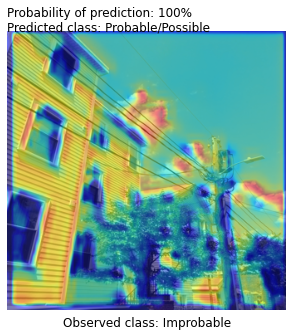

In [27]:
renderGradCam(0, True, False)

In [11]:
def renderGBP(index, activation_layer='conv2d_4', save=False, grid=False, c_map='gist_gray'): #normalize=False
    '''Visualizing Guided Backpropagation with an option to use normalized gradients.'''
    gbp = deprocess_image(np.squeeze(guided_backprop([index], activation_layer)))
    gbp_dir = '../../figures/plottingBackProp/'
    
    # Deprocessing is applied regardless of normalization. Therefore commenting out this case for both GB and Guided GCAM.
    #if normalize: 
    #    save_name = gbp_dir+"guided_backprop-"+str(index)+'-normalized-'+c_map+".png"
    #    gbp = deprocess_image(np.squeeze(gbp))
    #else:
    #    save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
    #    gbp = np.squeeze(gbp)
        
    if grid:
        plt.axis('off')
        plt.tight_layout()
#         plt.imshow(np.flip(gbp, -1), cmap=c_map) 
    else:
        standardizePlot(index, gbp_dir, 'Guided Backpropagation')    
        
    plt.imshow(np.flip(gbp, -1), cmap=c_map) # Reverse the order of elements, starting from the last axis, in order to compute saliency.
    
    if save:
        save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
        plt.savefig(save_name)
    return (gbp)

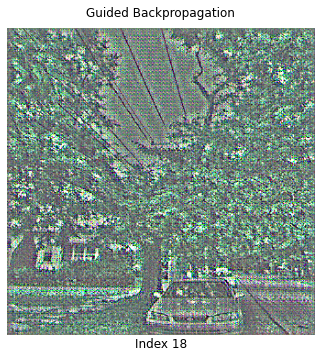

In [12]:
gbp1 = renderGBP(18, 'conv2d_4', False, False)

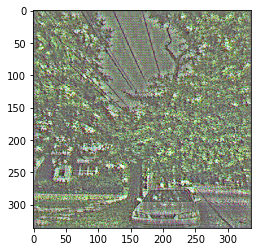

In [50]:
plt.imshow(np.squeeze(gbp1))

In [13]:
def renderGGCAM(index, activation_layer='conv2d_4', save=False, grid = False, c_map='gist_gray'): #normalize=False,
    '''Visualizing Guided Grad-CAM output with an option to use normalized guided backpropagation gradients.'''
    ggcam_dir = '../../figures/plottingGuided-GradCam/'
    plot_name = ''
    ggcam = deprocess_image(np.squeeze(guided_gradcam(index, activation_layer)))
    
    #if normalize:
    #    plot_name = "guided-gradcam-"+str(index)+'-'+c_map+'-normalized.png'
    #    ggcam = deprocess_image(ggcam)
    #    print('Using normalized GBP gradients...')
    #else:
    #    plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
    
    if grid:
        plt.axis('off')
        plt.tight_layout()
#         plt.imshow(np.flip(ggcam, -1), cmap=c_map) 
    else:
        standardizePlot(index, ggcam_dir, 'Guided Grad-CAM')
        
    plt.imshow(np.flip(ggcam, -1), cmap=c_map) # Reverse the order of elements, starting from the last axis, in order to compute saliency.   
    
    if save:
        plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
        plt.savefig(ggcam_dir+plot_name)
        print('Saving '+plot_name+' in '+ggcam_dir)
        
    return(ggcam)

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)


array([[[116, 117, 123],
        [119,  97, 110],
        [126, 126, 123],
        ...,
        [116, 138, 113],
        [129, 121, 132],
        [113, 113, 106]],

       [[116, 126, 110],
        [101, 112, 101],
        [131, 146, 117],
        ...,
        [118, 124, 132],
        [133, 130, 130],
        [110, 106, 122]],

       [[121, 120, 115],
        [133, 102, 128],
        [122, 128, 144],
        ...,
        [146, 115, 100],
        [138, 139, 106],
        [107,  89,  90]],

       ...,

       [[104, 110, 104],
        [116, 135, 141],
        [141, 171, 180],
        ...,
        [101,  96, 122],
        [126, 113, 125],
        [110, 108, 118]],

       [[102, 104,  83],
        [109, 112, 128],
        [137, 132, 112],
        ...,
        [119, 117, 121],
        [117, 126, 133],
        [131, 130, 128]],

       [[104, 120, 103],
        [114, 127, 115],
        [141, 116, 101],
        ...,
        [120, 120, 106],
        [108, 111, 109],
        [113, 114, 119]]

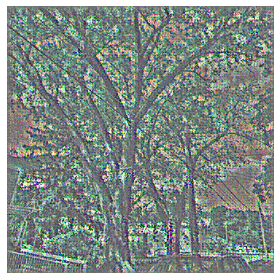

In [14]:
renderGGCAM(15, 'conv2d_4', False, True)

In [15]:
def plotVisualizations(index, activation_layer='conv2d_4', c_map='gist_gray', save=False):
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, activation_layer, False, True)
    ggcam = renderGGCAM(index, activation_layer, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image))
    axs[1].imshow(np.squeeze(orig_image))
    axs[1].imshow(gcam_heatmap, cmap=c_map, alpha=0.5)
    axs[2].imshow(gbp, cmap=c_map)
    axs[3].imshow(ggcam, cmap=c_map)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336, 3)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dty

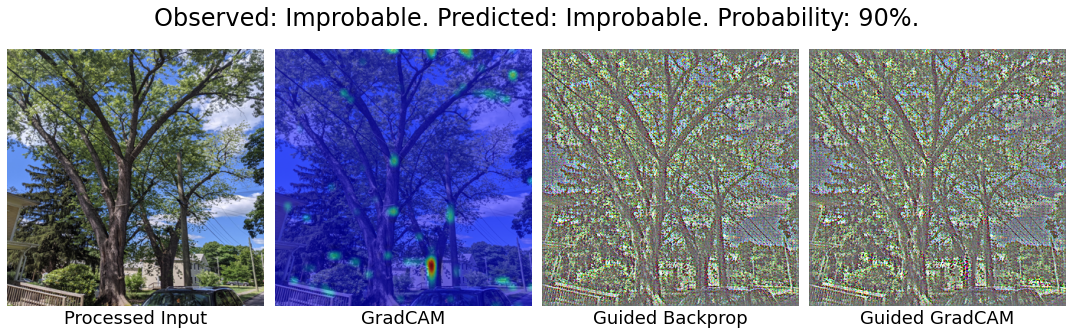

In [16]:
plotVisualizations(18, 'conv2d_4', 'gist_gray', False)